In [17]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
## collab user
# !pip install neuron
# !pip install netpyne
# !git clone https://github.com/suny-downstate-medical-center/S1_netpyne.git
# import os
# os.chdir('S1_netpyne/info')

In [2]:
import matplotlib
import os
os.chdir('../sim')

In [3]:
# !nrnivmodl -coreneuron mod/
# !nrnivmodl mod/

In [4]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.simType='run_subNets'
cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 1.0*1e3 ## Duration of the sim, in ms  
cfg.dt = 0.05
cfg.seeds = {'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = True

# S1 pop
cfg.poptypeNumber = 55 # m-types
cfg.celltypeNumber = 207 # me-types

cfg.rootFolder = os.getcwd()

In [5]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('../info/anatomy/S1-cells-distributions-Rat.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname

    if mtype not in popParam:
        popParam.append(mtype)
    
    cellParam.append(mtype + '_' + etype[0:3])
    
cfg.S1pops = popParam[0:55]
cfg.S1cells = cellParam[0:207]

#------------------------------------------------------------------------------  
# Thalamic Cells

cfg.thalamicpops = ['ss_RTN_o', 'ss_RTN_m', 'ss_RTN_i', 'VPL_sTC', 'VPM_sTC', 'POm_sTC_s1']

cfg.cellNumber['ss_RTN_o'] = int(382 * (210**2/150**2)) # from mouse model (d = 150 um)
cfg.cellNumber['ss_RTN_m'] = int(382 * (210**2/150**2))
cfg.cellNumber['ss_RTN_i'] = int(765 * (210**2/150**2))
cfg.cellNumber['VPL_sTC'] = int(656 * (210**2/150**2))
cfg.cellNumber['VPM_sTC'] = int(839 * (210**2/150**2))
cfg.cellNumber['POm_sTC_s1'] = int(685 * (210**2/150**2))

for mtype in cfg.thalamicpops: # No diversity
	metype = mtype
	popParam.append(mtype)
	cfg.popLabel[metype] = mtype
	cellParam.append(metype)

	cfg.popNumber[mtype] = cfg.cellNumber[metype]

#------------------------------------------------------------------------------  
cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

#------------------------------------------------------------------------------  
# number=0
# for mtype in cfg.S1pops:
#     for cellEl in range(np.size(cfg.popLabelEl[mtype])):
#         number+=1
#         print(number,cfg.popLabelEl[mtype][cellEl], cfg.popLabel[cfg.popLabelEl[mtype][cellEl]], popLabelEl[cfg.popLabelEl[mtype][cellEl]])

In [6]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
# Load cells info from previously saved using netpyne (False: load from HOC BBP files, slower)
loadcellsfromJSON = True

# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = True    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = False 

In [7]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		cellname, mtype, etype, n, m = line.split()
		metype = mtype + '_' + etype[0:3]
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [8]:
cfg.S1pops = popParam[0:55]
cfg.S1cells = cellParam[0:207]

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam

## Run only selected populations (me-types)

In [9]:
subPopLabels = cfg.S1pops[23:27] # [36:38] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14

subPopLabels = ['L4_NGC', 'L4_PC', 'L4_SP']

subPopLabels = cfg.S1pops
#------------------------------------------------------------------------------  
cfg.S1pops = subPopLabels
cfg.S1cells = []
for metype in cfg.cellParamLabels:
    if cfg.popLabel[metype] in subPopLabels:        
        cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

cfg.popParamLabels = cfg.S1pops
cfg.cellParamLabels = cfg.S1cells

cfg.cellNumber[metype]
cfg.popNumber[cfg.popLabel[metype]]
#------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   
    
#------------------------------------------------------------------------------  
## Change for testing
#------------------------------------------------------------------------------  
# cfg.cellNumber[metype] = 25
# cfg.popNumber[cfg.popLabel[metype]] = 25
# #------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   

1342

In [10]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)
                
        
cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False
cfg.recordTime = False
cfg.recordStep = 0.5    


cfg.saveDipolePops = cfg.S1cells

cfg.recordDipole = True
if cfg.recordDipole: cfg.saveDipoleCells = cfg.S1cells

In [11]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNets'
cfg.saveFolder = '../data/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = True	           	## Save json file
cfg.saveDataInclude = ['simData'] ## ['netParams', 'simConfig', 'net' ,'simData']  ##
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = False			
cfg.saveCellConns = False	

In [12]:
"""
netParams.py
"""
# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = 420.0 # x-dimension (horizontal length) size in um
netParams.sizeY = 2082.0 # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 420.0 # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume

# r = 210 um and hexagonal side length = 230.9 um

In [13]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	

cellModels = ['HH_full']

layer = {'1':[0.0, 0.079], '2': [0.079,0.151], '3': [0.151,0.320], '23': [0.079,0.320], '4':[0.320,0.412], '5': [0.412,0.664], '6': [0.664,1.0], 
'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

In [14]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [15]:
#------------------------------------------------------------------------------
# load data from S1 Raster
#------------------------------------------------------------------------------

## Load spkTimes and cells positions
with open('../data/spkTimes_v9_batch6_lowgsynCT.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)
spkTimes = simData['spkTimes']
cellsTags = simData['cellsTags']

# create custom list of spike times
cellsVSName = {}
popsVSName = {}
for cellLabel in spkTimes.keys():    
    cellme = cellLabel.split('_')[0:-1]    
    metype = cellme[0]
    for i in range(1,np.size(cellme)):
        metype += '_' + cellme[i]
                   
    if metype not in cellsVSName.keys():
        cellsVSName[metype] = []
        
    mtype = cfg.popLabel[metype]    
    if mtype not in popsVSName.keys():
        popsVSName[mtype] = []
        
    cellsVSName[metype].append('presyn_'+cellLabel)
    popsVSName[mtype].append('presyn_'+cellLabel)


In [37]:
cfg.cynradNumber = 16
cfg.fracmorphoradius = 1.0/4.0

excluderadius2a = (cfg.cynradNumber-1)*(0.5*cfg.fracmorphoradius)**2
excluderadius2b = (cfg.cynradNumber)*(0.5*cfg.fracmorphoradius)**2

Nmorpho = {}
for popLabel in cellsVSName.keys():
    Nmorpho[popLabel] = 0
    
print('radius',420*np.sqrt(excluderadius2a),420*np.sqrt(excluderadius2b))

radius 203.3316256758894 210.0


In [17]:
# create 1 vectstim pop per cell gid
for metype in cellsVSName.keys(): # metype
    
    cellsList = []            
    for cellLabel in cellsVSName[metype]: # all cells in metype

        if np.size(spkTimes[metype+'_'+cellLabel.split('_')[-1]]) == 0:
            spkTimes[metype+'_'+cellLabel.split('_')[-1]] = [15000.5]

        mtype = cfg.popLabel[metype]    

        ii = int(cellLabel.split('_')[-1])


        radiuscCell2 = (cellsTags[ii]['xnorm']-0.5)**2 + (cellsTags[ii]['znorm']-0.5)**2

        if metype[0] == 'L' and radiuscCell2 >= excluderadius2a and radiuscCell2 < excluderadius2b:   
            Nmorpho[metype] += 1
        else:
            cellsList.append({'cellLabel': int(cellLabel.split('_')[-1]), 'spkTimes': spkTimes[metype+'_'+cellLabel.split('_')[-1]]})

    if  Nmorpho[metype] > 0 and metype[0] == 'L':
        
        layernumber = metype[1:2]
        if layernumber == '2':
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                                'numCells': int(Nmorpho[metype]), 'diversity': True}
        else:
            netParams.popParams[metype] = {'cellType': metype, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                                'numCells': int(Nmorpho[metype]), 'diversity': True}
            
    if np.size(cellsList) > 0:
        netParams.popParams['presyn_'+metype] = {'cellModel': 'VecStim', 'cellsList': cellsList}
        
    print(metype,np.size(cellsList),Nmorpho[metype],cfg.cellNumber[metype])

L1_DAC_bNA 19 0 19
L1_DAC_cNA 36 3 39
L1_DLAC_cNA 24 0 24
L1_HAC_bNA 19 0 19
L1_HAC_cIR 9 1 10
L1_HAC_cNA 58 4 62
L1_NGC-DA_bNA 8 0 8
L1_NGC-DA_cAC 8 0 8
L1_NGC-DA_cNA 47 1 48
L1_NGC-DA_cST 8 0 8
L1_NGC-SA_cNA 48 4 52
L1_SLAC_bNA 12 2 14
L1_SLAC_cAC 8 0 8
L1_SLAC_cNA 17 2 19
L23_BP_bAC 3 0 3
L23_BP_bIR 4 0 4
L23_BP_bNA 6 1 7
L23_BP_cAC 7 0 7
L23_BP_cNA 3 1 4
L23_BP_dST 3 0 3
L23_BTC_bAC 15 0 15
L23_BTC_bIR 7 0 7
L23_BTC_bNA 19 4 23
L23_BTC_cAC 38 3 41
L23_BTC_cNA 16 2 18
L23_ChC_cAC 23 0 23
L23_ChC_cNA 21 2 23
L23_ChC_dNA 15 0 15
L23_DBC_bAC 12 0 12
L23_DBC_bIR 30 2 32
L23_DBC_bNA 65 5 70
L23_DBC_cAC 58 3 61
L23_LBC_bAC 33 2 35
L23_LBC_bNA 27 0 27
L23_LBC_cAC 104 4 108
L23_LBC_cNA 67 9 76
L23_LBC_cST 21 1 22
L23_LBC_dNA 177 11 188
L23_MC_bAC 10 0 10
L23_MC_bNA 10 0 10
L23_MC_cAC 251 19 270
L23_MC_cNA 31 2 33
L23_MC_dNA 10 0 10
L23_NBC_bAC 14 0 14
L23_NBC_bNA 5 1 6
L23_NBC_cAC 62 3 65
L23_NBC_cIR 6 0 6
L23_NBC_cNA 74 6 80
L23_NBC_dNA 90 7 97
L23_NGC_bNA 5 0 5
L23_NGC_cAC 5 0 5
L23_NGC_c

In [18]:
Epopsall = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
Epops = [] 
cfg.popLabelEl = {}

for metype in cellsVSName.keys(): # metype  
    
    if  Nmorpho[metype] > 0:  
        mtype = cfg.popLabel[metype]    
        
        if mtype in Epopsall:
            
            if mtype not in Epops:
                Epops.append(mtype)
                cfg.popLabelEl[mtype] = [] 

            cfg.popLabelEl[mtype].append(metype)
            
        else:
            
            if mtype not in Ipops:                
                Ipops.append(mtype)    
                cfg.popLabelEl[mtype] = [] 

            cfg.popLabelEl[mtype].append(metype)        

In [19]:
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
if not loadcellsfromJSON:     ## Load cell rules using BBP template
    
    def loadTemplateName(cellMe):     
        outFolder = cfg.rootFolder+'/cell_data/'+cellMe
        try:
            f = open(outFolder+'/template.hoc', 'r')
            for line in f.readlines():
                if 'begintemplate' in line:
                    return str(line)[14:-1]     
        except:
            print('Cannot read cell template from %s' % (outFolder))
            return False

    cellnumber = 0    
    for cellName in cfg.S1cells:

        if cfg.cellNumber[cellName] < 5:
            morphoNumbers = cfg.cellNumber[cellName]
        else:
            morphoNumbers = 5

        for morphoNumber in range(morphoNumbers):
            cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
            print(cellMe,cellName)

            cellTemplateName = loadTemplateName(cellMe)

            if cellTemplateName:

                cellRule = netParams.importCellParams(label=cellMe, somaAtOrigin=True,
                    conds={'cellType': cellMe, 'cellModel': 'HH_full'},
                    fileName='cellwrapper.py',
                    cellName='loadCell',
                    cellInstance = True,
                    cellArgs={'cellName': cellMe, 'cellTemplateName': cellTemplateName})

                netParams.renameCellParamsSec(label=cellMe, oldSec='soma_0', newSec='soma')              
                for secname2 in netParams.cellParams[cellMe]['secLists'].keys():
                 if 'soma_0' in netParams.cellParams[cellMe]['secLists'][secname2]:
                   print(cellMe,secname2,netParams.cellParams[cellMe]['secLists'][secname2][0])
                   netParams.cellParams[cellMe]['secLists'][secname2][0] = 'soma'    

In [20]:
## S1 cell property rules
cellnumber = 0    
for cellName in cfg.S1cells:

    if Nmorpho[cellName] < 5:
        morphoNumbers = Nmorpho[cellName]
    else:
        morphoNumbers = 5    
    
    for morphoNumber in range(morphoNumbers):
        
        cellFraction = 1.0/morphoNumbers
        
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
        
        if loadcellsfromJSON:
            # Load cell rules previously saved using netpyne format
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cell_data/' + cellMe + '/' + cellMe + '_cellParams.json')            
        else:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['secs'] = netParams.cellParams[cellMe]['secs']     
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['conds']['cellType'] = cellName
            cellRule['globals'] = netParams.cellParams[cellMe]['globals']       
            cellRule['secLists'] = netParams.cellParams[cellMe]['secLists']      
            cellRule['secLists']['spiny'] = {}
            cellRule['secLists']['spinyEE'] = {}
            nonSpiny = ['axon_0', 'axon_1']
            cellRule['secLists']['spiny'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpiny]
            nonSpinyEE = ['axon_0', 'axon_1', 'soma']
            cellRule['secLists']['spinyEE'] = [sec for sec in cellRule['secLists']['all'] if sec not in nonSpinyEE]
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params  

        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['secs'] = {}
            cellRule['secs']['soma'] = netParams.cellParams[cellMe]['secs']['soma']
            cellRule['secLists'] = {}
            cellRule['secLists']['spiny'] = ['soma']
            cellRule['secLists']['spinyEE'] = ['soma']
            cellRule['secLists']['all'] = ['soma']
            cellRule['secLists']['basal'] = ['soma']   
            cellRule['secLists']['apical'] = ['soma']    
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
        #-----------------------------------------------------------------------------------#

In [21]:
# # Save cells info in JSON
# for cellName in cfg.S1cells:    
#     if cfg.cellNumber[cellName] < 5:
#         morphoNumbers = cfg.cellNumber[cellName]
#     else:
#         morphoNumbers = 5    
    
#     for morphoNumber in range(morphoNumbers):
#         cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)
#         outFolder = cfg.rootFolder+'/cell_data/'+cellMe
#         netParams.saveCellParamsRule(label=cellMe, fileName=outFolder+'/'+cellMe+'_cellParams.json')

In [22]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

In [23]:
import pandas as pd

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.55,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,II
3,1,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
13,2,0.75,0.32,10.4,6.1,0.415,0.212,162.0,69.0,690.0,5.0,I1,IE
1,3,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
4,4,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
12,8,2.97,0.95,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
5,9,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE


In [24]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from S1 BBP - deterministic version
#------------------------------------------------------------------------------
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

In [25]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed - Spont and BG
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}

In [26]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

contA = 0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:    
#                 print('\n-------------------------------------------------------------------------------------------\n                               %s:%s                               \n-------------------------------------------------------------------------------------------' % (pre,post)) 
            
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}        
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                       
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

In [27]:
# contA = 0
# contB = 0
# contC = 0
# for connpath in netParams.connParams.keys():
#     if '_B' in connpath[-2:]:
#         contB+=1        
# #         print()
# #         print(connpathAnt)
# #         print(netParams.connParams[connpathAnt])
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     elif '_C' in connpath[-2:]:
#         contC+=1        
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     else:        
#         contA+=1        
#     connpathAnt = connpath
# print(contA,contB,contC)
# print(contA+contB+contC)

In [28]:
#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 9.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'AMPA', 
                'sec': 'spinyEE', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'spiny', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'GABAA', 
                'sec': 'spiny', 
                'weight': GsynStimI[post],
                'delay': 0.1}

In [29]:
# for stimpath in netParams.stimSourceParams.keys():
#     print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

In [30]:
# for stimpath in netParams.stimTargetParams.keys():
#     print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

## Run small Nets in a sigle job

In [31]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params

sim.net.createPops()               			# instantiate network populations


Start time:  2022-09-02 11:59:38.466973


{presyn_L1_DAC_bNA: <netpyne.network.pop.Pop object at 0x7f4b10fe9b20>, L1_DAC_cNA: <netpyne.network.pop.Pop object at 0x7f4b11372fa0>, presyn_L1_DAC_cNA: <netpyne.network.pop.Pop object at 0x7f4b113802b0>, presyn_L1_DLAC_cNA: <netpyne.network.pop.Pop object at 0x7f4b113800d0>, presyn_L1_HAC_bNA: <netpyne.network.pop.Pop object at 0x7f4b11380160>, L1_HAC_cIR: <netpyne.network.pop.Pop object at 0x7f4b0bfaf760>, presyn_L1_HAC_cIR: <netpyne.network.pop.Pop object at 0x7f4b0bfafc40>, L1_HAC_cNA: <netpyne.network.pop.Pop object at 0x7f4b2be02c10>, presyn_L1_HAC_cNA: <netpyne.network.pop.Pop object at 0x7f4b0bfaf310>, presyn_L1_NGC-DA_bNA: <netpyne.network.pop.Pop object at 0x7f4b0bfaf490>, presyn_L1_NGC-DA_cAC: <netpyne.network.pop.Pop object at 0x7f4b0bfafa30>, L1_NGC-DA_cNA: <netpyne.network.pop.Pop object at 0x7f4b0bfaf850>, presyn_L1_NGC-DA_cNA: <netpyne.network.pop.Pop object at 0x7f4b0bfafb80>, presyn_L1_NGC-DA_cST: <netpyne.network.pop.Pop object at 0x7f4b0bfafd30>, L1_NGC-SA_cNA: <n

In [32]:
sim.net.createCells();              			# instantiate network cells based on defined populations


Creating network of 318 cell populations on 1 hosts...
  Number of cells on node 0: 38612 
  Done; cell creation time = 5.67 s.


In [33]:
## Load cells positions
with open('../data/spkTimes_v9_batch8_highgsynCT.pkl', 'rb') as fileObj: simData = pickle.load(fileObj)

cellsTags = simData['cellsTags']

print(sim.rank,sim.net.cells[0].tags)
print(sim.rank,sim.net.cells[31345].tags)
print(sim.rank,sim.net.cells[-1].tags)

0 {'cellModel': 'VecStim', 'pop': 'presyn_L1_DAC_bNA', 'cellLabel': 0, 'spkTimes': [15000.5], 'xnorm': 0, 'x': 0, 'ynorm': 0, 'y': 0, 'znorm': 0, 'z': 0}
0 {'cellModel': 'VecStim', 'pop': 'presyn_L6_UTPC_cAD', 'cellLabel': 31345, 'spkTimes': [15000.5], 'xnorm': 0, 'x': 0, 'ynorm': 0, 'y': 0, 'znorm': 0, 'z': 0}
0 {'cellModel': 'VecStim', 'pop': 'presyn_POm_sTC_s1', 'cellLabel': 38611, 'spkTimes': [145.40000002965462, 325.42500004013345, 500.9750000503518, 674.2250000604363, 1027.7250000810127, 1543.2500001110202, 1706.6000001205284, 1875.4750001303582, 2051.4250001406, 2218.6000001503307, 2398.825000160821, 2567.1750001706205, 2725.3500001798275, 2895.9250001897562, 3077.8000002003428, 3252.350000210503, 3413.4250002198787, 3585.2000002298773, 3766.700000240442, 3944.47500025079, 4121.375000261087, 4296.250000271266, 4461.300000280873, 4636.82500029109, 4812.800000301333, 5148.675000320884, 5488.325000340654, 5668.200000351124, 6006.325000370805, 6182.725000381073, 6339.500000390199, 6

In [35]:
cellNumberi = {}
cellNbr = 0
for metype in cfg.cellNumber.keys():
    cellNumberi[metype] = cellNbr
    cellNbr += cfg.cellNumber[metype]

# print(sim.rank,sim.net.cells[0].tags)

for i,metype in enumerate(sim.net.cells):

    if 'presyn' in metype.tags['pop']:
        ii = int(metype.tags['cellLabel'])        
        metype.tags['xnorm'] = cellsTags[ii]['xnorm']
        metype.tags['ynorm'] = cellsTags[ii]['ynorm']
        metype.tags['znorm'] = cellsTags[ii]['znorm']
        metype.tags['x'] = cellsTags[ii]['x']
        metype.tags['y'] = cellsTags[ii]['y']
        metype.tags['z'] = cellsTags[ii]['z']   

    else:
        
        print(i,metype.tags['pop'],cellNumberi[metype.tags['pop']]+int(0.000001+(metype.tags['fraction']/(1/Nmorpho[metype.tags['pop']]))))
        
        ii = int(0.000001+(metype.tags['fraction']/(1/Nmorpho[metype.tags['pop']])))    
        metype.tags['xnorm'] = cellsTags[ii]['xnorm']
        metype.tags['ynorm'] = cellsTags[ii]['ynorm']
        metype.tags['znorm'] = cellsTags[ii]['znorm']
        metype.tags['x'] = cellsTags[ii]['x']
        metype.tags['y'] = cellsTags[ii]['y']
        metype.tags['z'] = cellsTags[ii]['z']   

19 L1_DAC_cNA 19
20 L1_DAC_cNA 20
21 L1_DAC_cNA 21
101 L1_HAC_cIR 101
111 L1_HAC_cNA 111
112 L1_HAC_cNA 112
113 L1_HAC_cNA 113
114 L1_HAC_cNA 114
189 L1_NGC-DA_cNA 189
245 L1_NGC-SA_cNA 245
246 L1_NGC-SA_cNA 246
247 L1_NGC-SA_cNA 247
248 L1_NGC-SA_cNA 248
297 L1_SLAC_bNA 297
298 L1_SLAC_bNA 298
319 L1_SLAC_cNA 319
320 L1_SLAC_cNA 320
345 L23_BP_bNA 345
359 L23_BP_cNA 359
388 L23_BTC_bNA 388
389 L23_BTC_bNA 389
390 L23_BTC_bNA 390
391 L23_BTC_bNA 391
411 L23_BTC_cAC 411
412 L23_BTC_cAC 412
413 L23_BTC_cAC 413
452 L23_BTC_cNA 452
453 L23_BTC_cNA 453
493 L23_ChC_cNA 493
494 L23_ChC_cNA 494
543 L23_DBC_bIR 543
544 L23_DBC_bIR 544
575 L23_DBC_bNA 575
576 L23_DBC_bNA 576
577 L23_DBC_bNA 577
578 L23_DBC_bNA 578
579 L23_DBC_bNA 579
645 L23_DBC_cAC 645
646 L23_DBC_cAC 646
647 L23_DBC_cAC 647
706 L23_LBC_bAC 706
707 L23_LBC_bAC 707
768 L23_LBC_cAC 768
769 L23_LBC_cAC 769
770 L23_LBC_cAC 770
771 L23_LBC_cAC 771
876 L23_LBC_cNA 876
877 L23_LBC_cNA 877
878 L23_LBC_cNA 878
879 L23_LBC_cNA 879
880 L2

In [122]:
cfg.cellNumber[sim.net.cells[170].tags['pop']]

KeyError: 'presyn_L1_NGC-DA_bNA'

In [40]:
for i,metype in enumerate(sim.net.cells):      
    if 'presyn' not in metype.tags['pop']:
        print(i,sim.net.cells[i].tags['pop'],sim.net.cells[i].tags['fraction'],1/Nmorpho[sim.net.cells[i].tags['pop']])

56 L1_DAC_cNA 0.0 0.5
57 L1_DAC_cNA 0.5 0.5
170 L1_HAC_cNA 0.0 0.3333333333333333
171 L1_HAC_cNA 0.3333333333333333 0.3333333333333333
172 L1_HAC_cNA 0.6666666666666666 0.3333333333333333
293 L1_NGC-SA_cNA 0.0 0.25
294 L1_NGC-SA_cNA 0.25 0.25
295 L1_NGC-SA_cNA 0.5 0.25
296 L1_NGC-SA_cNA 0.75 0.25
310 L1_SLAC_bNA 0.0 1.0
337 L1_SLAC_cNA 0.0 1.0
351 L23_BP_bNA 0.0 1.0
362 L23_BP_cNA 0.0 1.0
408 L23_BTC_bNA 0.0 0.3333333333333333
409 L23_BTC_bNA 0.3333333333333333 0.3333333333333333
410 L23_BTC_bNA 0.6666666666666666 0.3333333333333333
450 L23_BTC_cAC 0.0 0.5
451 L23_BTC_cAC 0.5 0.5
468 L23_BTC_cNA 0.0 0.5
469 L23_BTC_cNA 0.5 0.5
642 L23_DBC_bNA 0.0 0.3333333333333333
643 L23_DBC_bNA 0.3333333333333333 0.3333333333333333
644 L23_DBC_bNA 0.6666666666666666 0.3333333333333333
704 L23_DBC_cAC 0.0 0.5
705 L23_DBC_cAC 0.5 0.5
739 L23_LBC_bAC 0.0 0.5
740 L23_LBC_bAC 0.5 0.5
873 L23_LBC_cAC 0.0 0.3333333333333333
874 L23_LBC_cAC 0.3333333333333333 0.3333333333333333
875 L23_LBC_cAC 0.66666666666

In [33]:
for ii in range(31345):
    for jj in range(3):
        print(sim.net.cells[ii].tags['pop'],sim.net.cells[ii].tags['fraction'],jj/cfg.cellNumber[sim.net.cells[ii].tags['pop']])

L1_HAC_cNA 0.0 0.0
L1_HAC_cNA 0.0 0.016129032258064516
L1_HAC_cNA 0.0 0.03225806451612903
L1_HAC_cNA 0.3333333333333333 0.0
L1_HAC_cNA 0.3333333333333333 0.016129032258064516
L1_HAC_cNA 0.3333333333333333 0.03225806451612903
L1_HAC_cNA 0.6666666666666666 0.0
L1_HAC_cNA 0.6666666666666666 0.016129032258064516
L1_HAC_cNA 0.6666666666666666 0.03225806451612903


In [108]:
print(sim.rank,sim.net.cells[31344].tags,sim.rank,sim.net.cells[31344].gid,)

0 {'cellType': 'L6_UTPC_cAD', 'cellModel': 'HH_full', 'pop': 'L6_UTPC_cAD', 'xnorm': 0.1485357797516041, 'ynorm': 0.7576078728182223, 'znorm': 0.5241456213225473, 'x': 62.38502749567372, 'y': 1577.339591207539, 'z': 220.14116095546984, 'fraction': 0.974025974025974} 0 31344


In [109]:
print(sim.rank,sim.net.cells[31345].tags,sim.rank,sim.net.cells[31345].gid)

0 {'cellType': 'L6_UTPC_cAD', 'cellModel': 'HH_full', 'pop': 'L6_UTPC_cAD', 'xnorm': 0.08331349542043137, 'ynorm': 0.6846848127756536, 'znorm': 0.5323680173075332, 'x': 34.99166807658118, 'y': 1425.5137801989108, 'z': 223.59456726916397, 'fraction': 0.987012987012987} 0 31345


In [105]:
print(sim.rank,sim.net.cells[0].tags)
print(sim.rank,sim.net.cells[31344].tags)
print(sim.rank,sim.net.cells[-1].tags)

0 {'cellModel': 'VecStim', 'pop': 'presyn_L1_DAC_bNA', 'cellLabel': 0, 'spkTimes': [15000.5], 'xnorm': 0.2626944415792011, 'x': 110.33166546326446, 'ynorm': 0.056717437071558685, 'y': 118.08570398298518, 'znorm': 0.6996418350378355, 'z': 293.84957071589093}
0 {'cellType': 'L6_UTPC_cAD', 'cellModel': 'HH_full', 'pop': 'L6_UTPC_cAD', 'xnorm': 0.1485357797516041, 'ynorm': 0.7576078728182223, 'znorm': 0.5241456213225473, 'x': 62.38502749567372, 'y': 1577.339591207539, 'z': 220.14116095546984, 'fraction': 0.974025974025974}
0 {'cellType': 'L6_UTPC_cAD', 'cellModel': 'HH_full', 'pop': 'L6_UTPC_cAD', 'xnorm': 0.08331349542043137, 'ynorm': 0.6846848127756536, 'znorm': 0.5323680173075332, 'x': 34.99166807658118, 'y': 1425.5137801989108, 'z': 223.59456726916397, 'fraction': 0.987012987012987}
0 {'cellModel': 'VecStim', 'pop': 'presyn_POm_sTC_s1', 'cellLabel': 38611, 'spkTimes': [145.40000002965462, 325.42500004013345, 500.9750000503518, 674.2250000604363, 1027.7250000810127, 1543.2500001110202, 

In [102]:
# sim.net.connectCells()            			# create connections between cells based on params
# sim.net.addStims() 							# add network stimulation
# sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
# sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  


Gathering data...
  Done; gather time = 2.63 s.

Analyzing...
  Cells: 38612
  Connections: 0 (0.00 per cell)
Saving output as ../data/subNets/subNets_data.json ... 
Finished saving!
  Done; saving time = 0.02 s.
  Done; plotting time = 0.00 s


## Net infos

Plotting connectivity matrix...


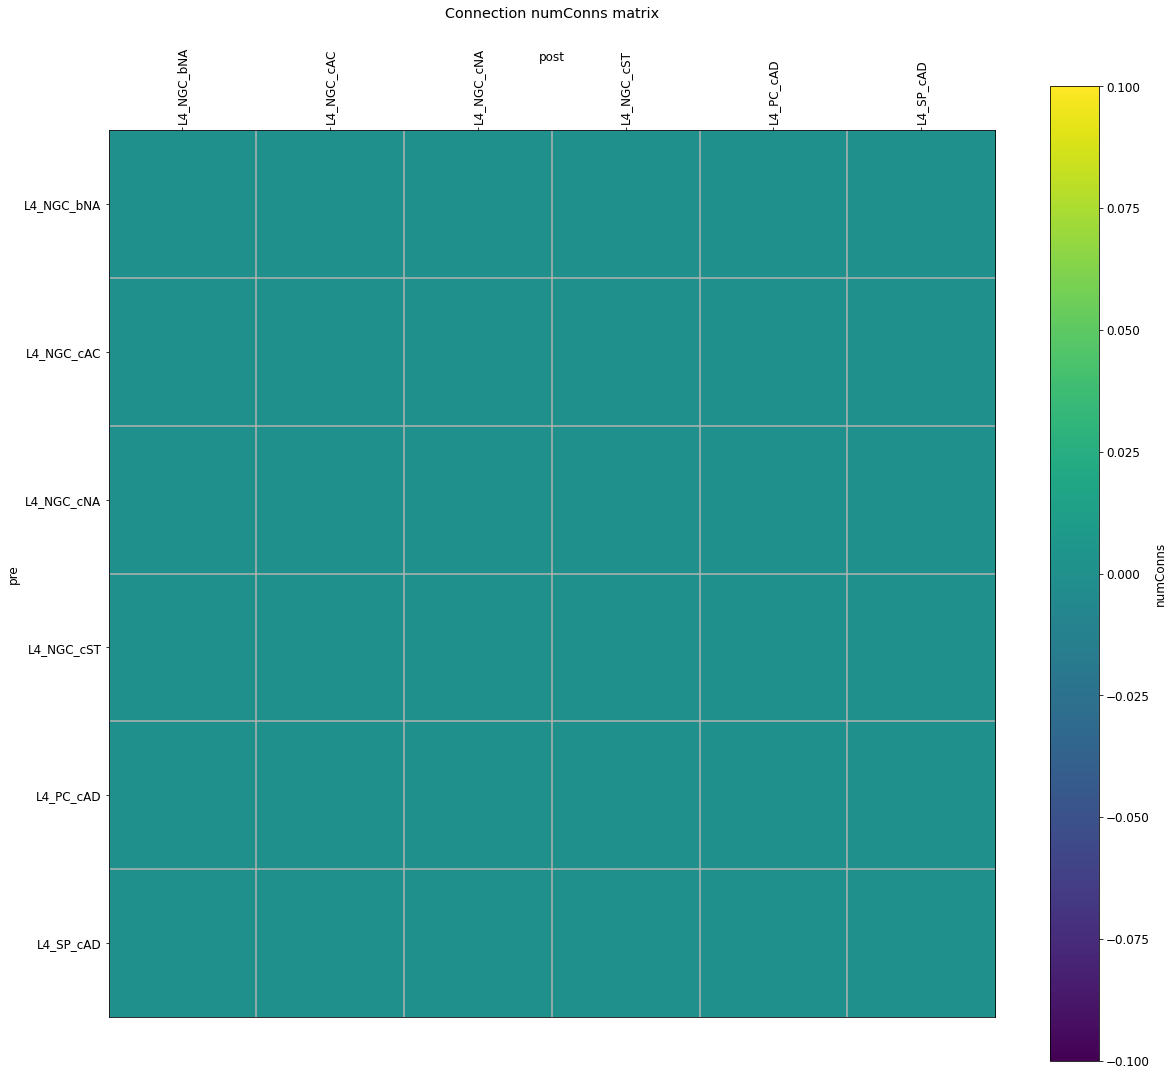

In [34]:
# features = ['numConns','convergence']
test = sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature='numConns', figSize=(18, 18), fontSize=12, saveData=None, 
                               saveFig=True, showFig=False);

In [35]:
connNumber = connData['connNumber']
synperconnNumber = connData['synperconnNumber']
     
connNetPyNE = {}
for pre in subPopLabels:
    connNetPyNE[pre] = {}
    for post in subPopLabels:        
        connNetPyNE[pre][post] = 0
            
i=0
for pre in subPopLabels:
    for cellpre in cfg.popLabelEl[pre]:
        j=0
        for post in subPopLabels:
            for cellpost in cfg.popLabelEl[post]:
                 
                connBBP = float(connNumber[pre][post])
                if connBBP > 0:
                    synperconn = int(synperconnNumber[pre][post]+0.5)       

                    connNetPyNE[pre][post] += test[1]['connMatrix'][i][j]/synperconn
#                 print(i,j,test[1]['connMatrix'][i][j]/synperconn)
                j+=1
        i+=1
  
for pre in subPopLabels:
    for post in subPopLabels:  
            connBBP = float(connNumber[pre][post])      
            if connBBP>0: # pre not in Epops and post not in Epops and 
                print('\t%s->%s  \t - \t  BBP = %5.1f   \t    NetPyNE = %5.1f  \t   Error = %5.1f' % (pre,post,connBBP,connNetPyNE[pre][post],100*(connNetPyNE[pre][post]-connBBP)/connBBP),'%')


	L4_NGC->L4_PC  	 - 	  BBP = 199.3   	    NetPyNE =   0.0  	   Error = -100.0 %
	L4_NGC->L4_SP  	 - 	  BBP =  63.9   	    NetPyNE =   0.0  	   Error = -100.0 %
	L4_PC->L4_NGC  	 - 	  BBP =  64.6   	    NetPyNE =   0.0  	   Error = -100.0 %
	L4_PC->L4_PC  	 - 	  BBP = 136716.0   	    NetPyNE =   0.0  	   Error = -100.0 %
	L4_PC->L4_SP  	 - 	  BBP = 46520.1   	    NetPyNE =   0.0  	   Error = -100.0 %
	L4_SP->L4_NGC  	 - 	  BBP =  22.4   	    NetPyNE =   0.0  	   Error = -100.0 %
	L4_SP->L4_PC  	 - 	  BBP = 49602.6   	    NetPyNE =   0.0  	   Error = -100.0 %
	L4_SP->L4_SP  	 - 	  BBP = 14404.6   	    NetPyNE =   0.0  	   Error = -100.0 %


Plotting 2D representation of network cell locations and connections...


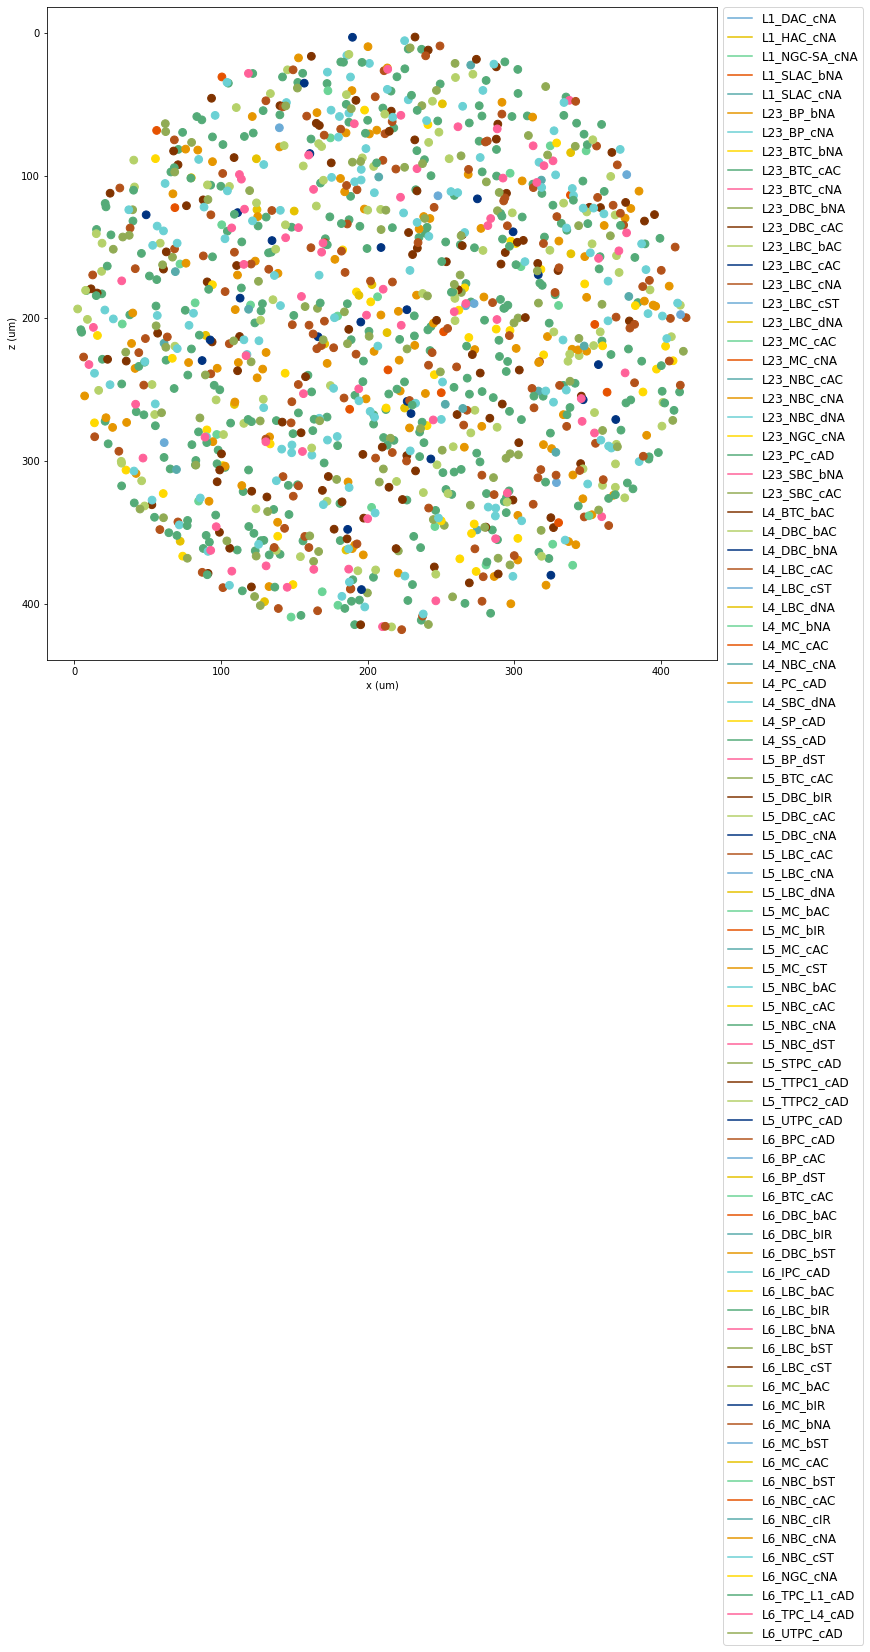

In [104]:
# sim.analysis.plot2Dnet(include=cfg.allpops, view='xy', showConns=True, 
#                                popColors=None, tagsFile=None, figSize=(12, 12), fontSize=8, saveData=None, 
#                                saveFig=False, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=cfg.allpops,view='xz', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(12, 12), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);
# sim.analysis.plot2Dnet(include=subPopLabels,view='xz', showConns=False, 
#                                popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
#                                saveFig=None, showFig=True, lineWidth=0.1);

## Raster and traces

Preparing spike data...
Plotting raster...


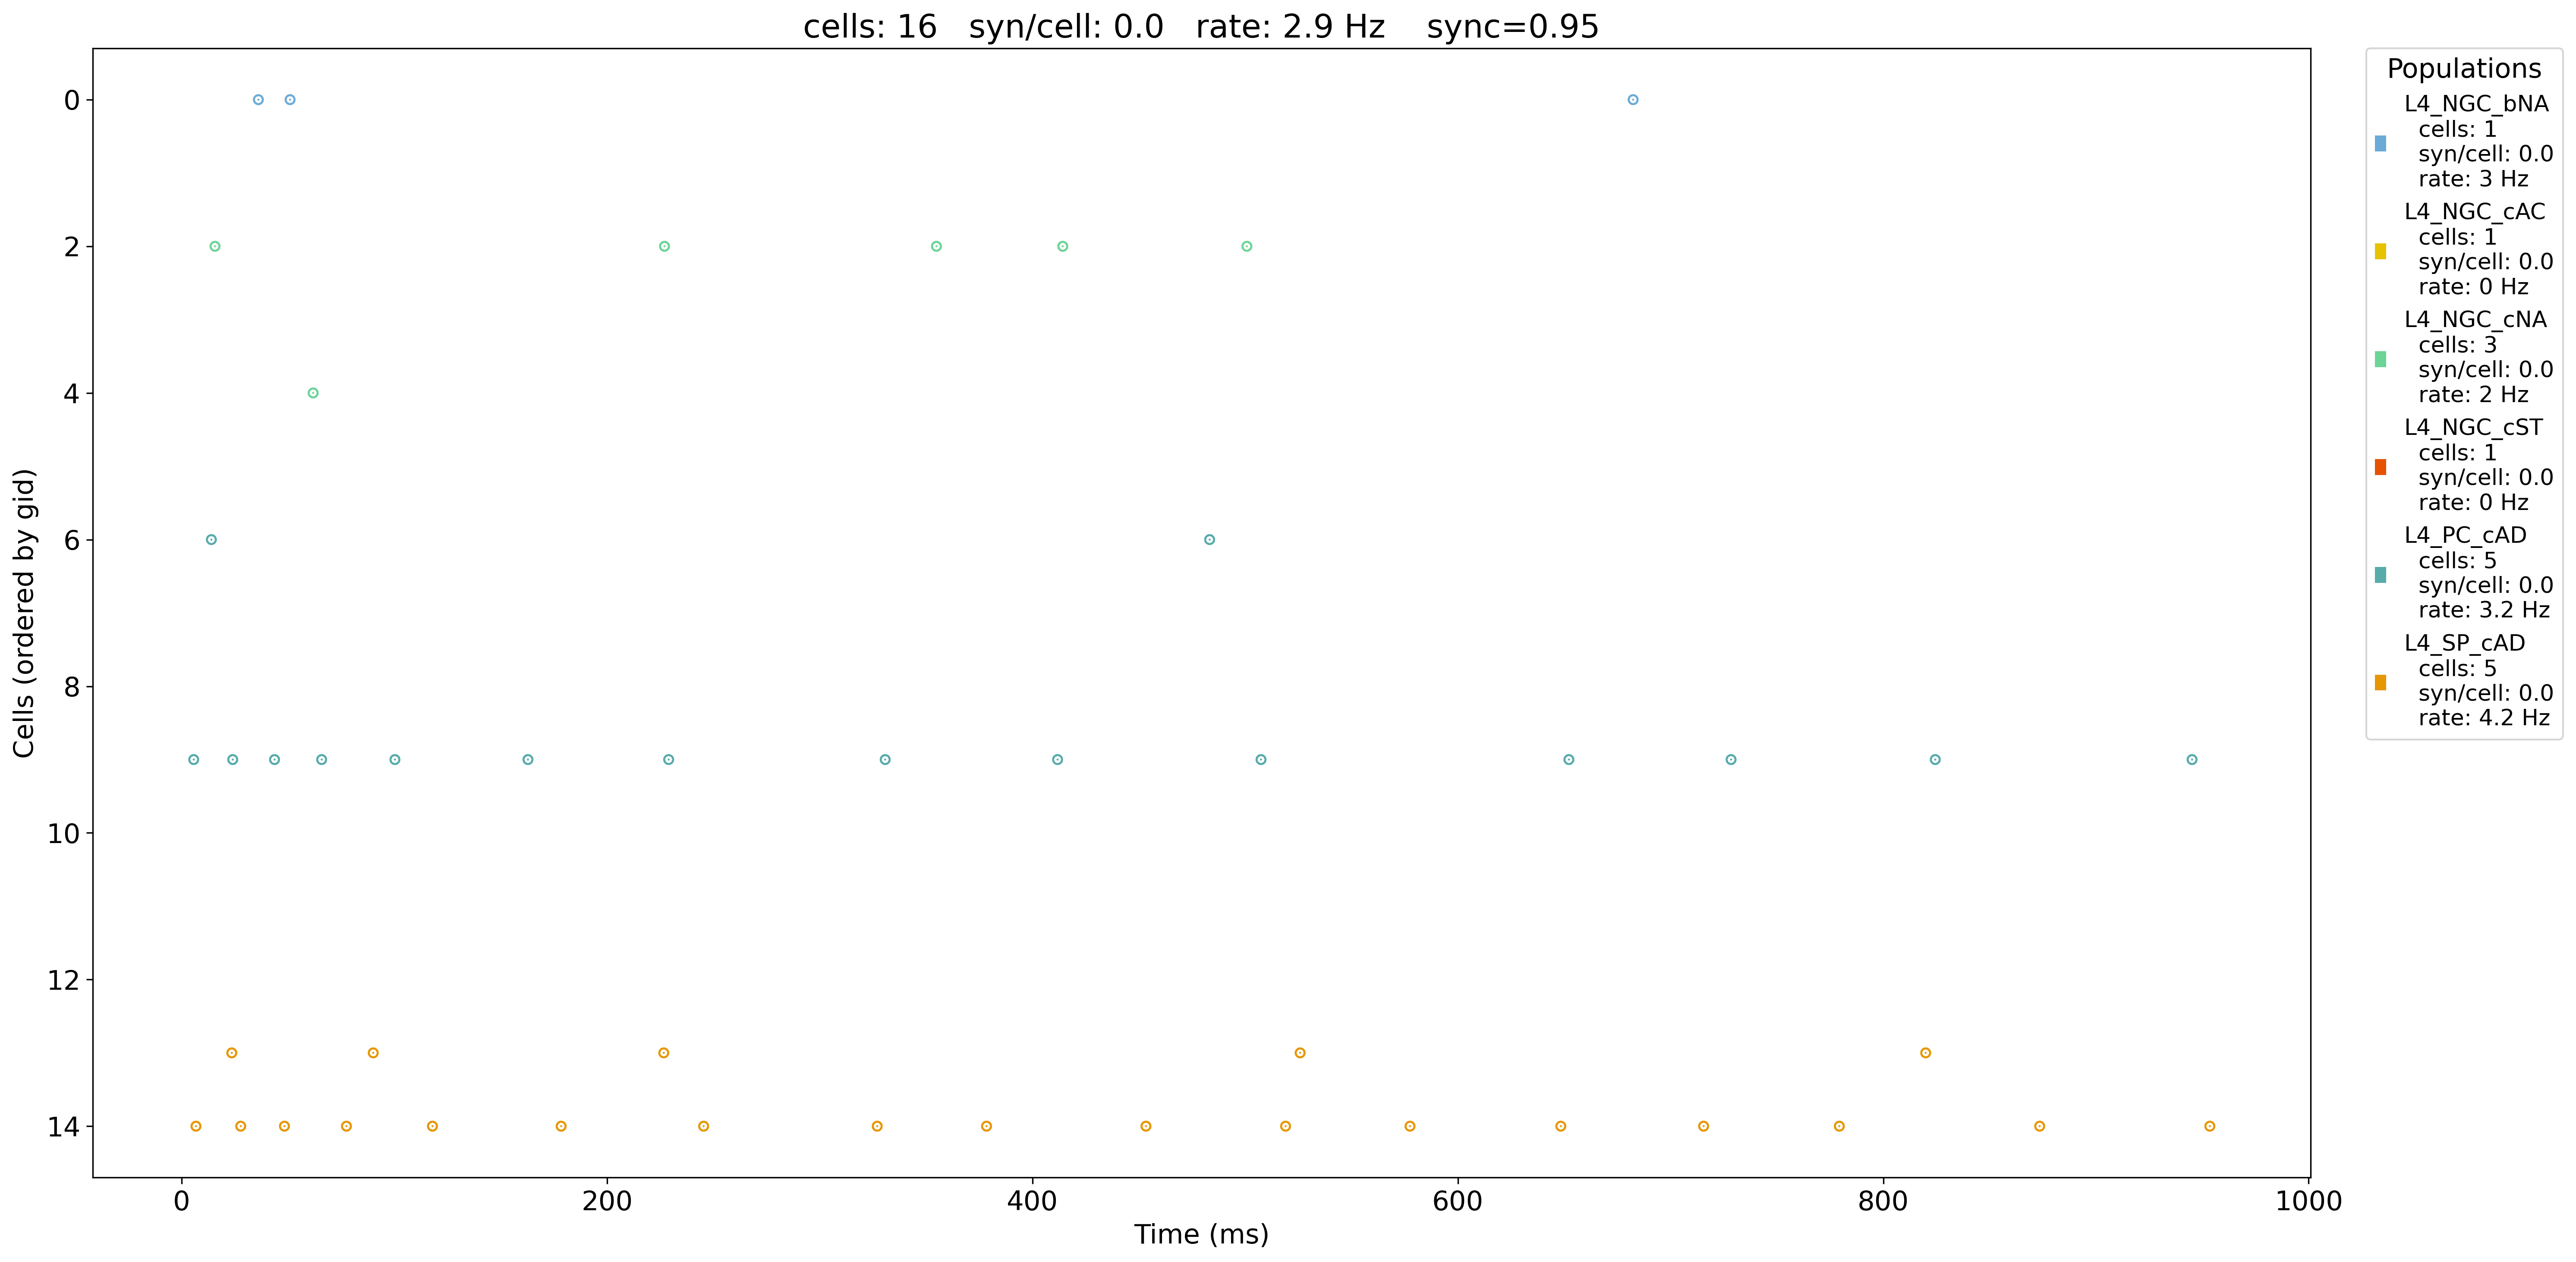

In [45]:
sim.analysis.plotRaster(include=cfg.allpops, timeRange=[0,cfg.duration], orderBy='gid', orderInverse=True, labels='legend', popRates=True, lw=5, marker='.', markerSize=24, figSize=(20, 10), fontSize=20, dpi=300, saveFig=True, showFig=False);

In [38]:
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:
#         print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])     

# traces = [(mtype, [i for i in range(0,cfg.popNumber[mtype],int(cfg.popNumber[mtype]/4.5))]) for mtype in subPopLabels]
# traces

In [46]:
# sim.analysis.plotTraces(timeRange=[400,cfg.duration], overlay=False, oneFigPer='trace', ylim=[-90,50], subtitles= False, axis=False, scaleBarLoc=1, figSize=(24, 7), fontSize=12, saveFig=True);

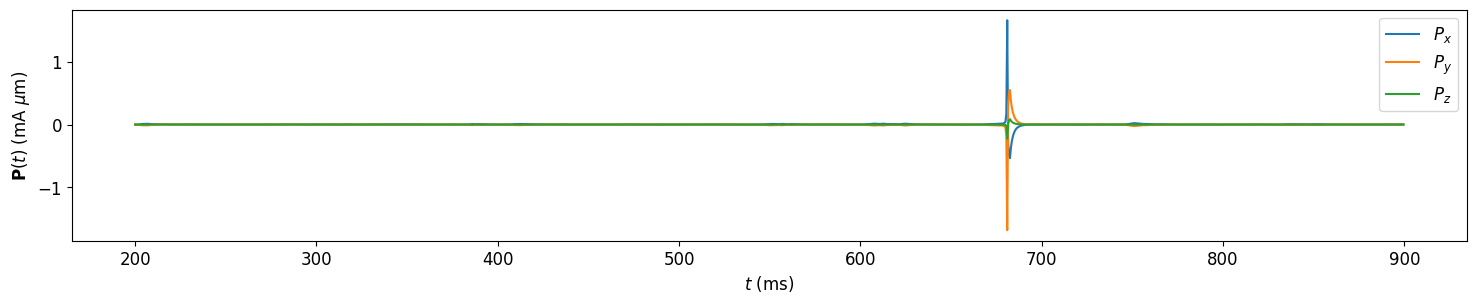

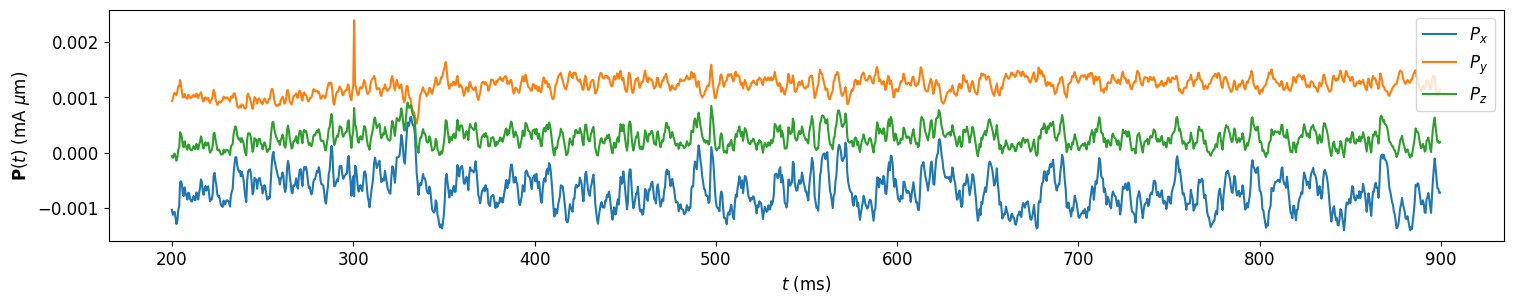

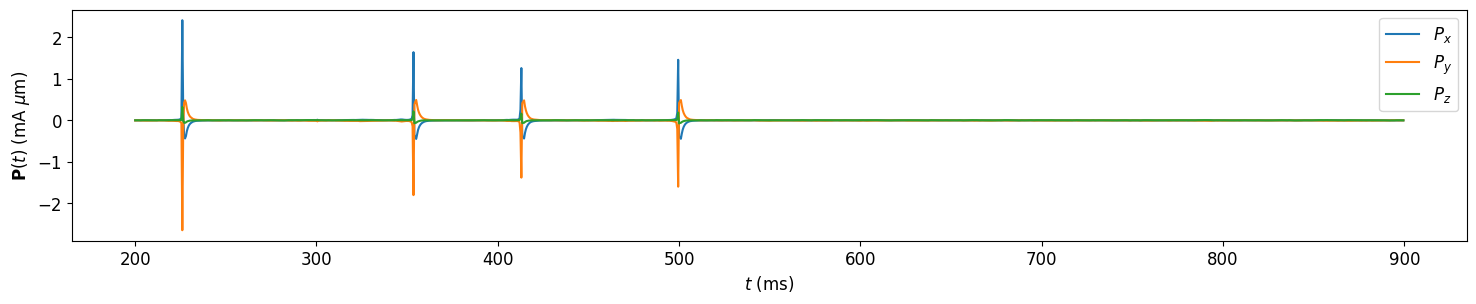

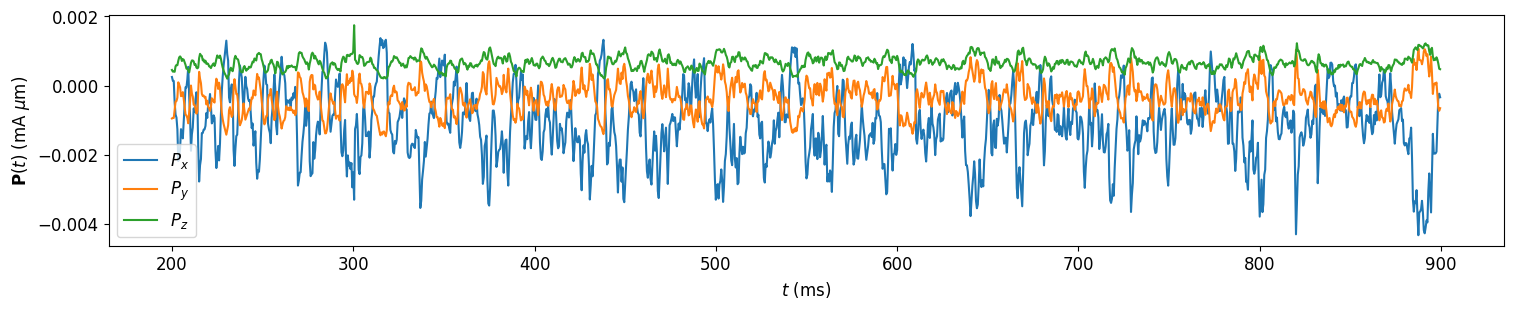

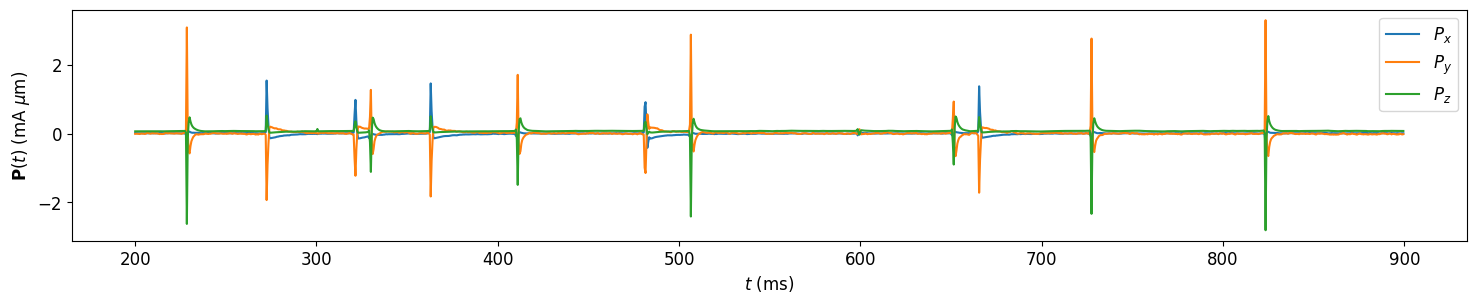

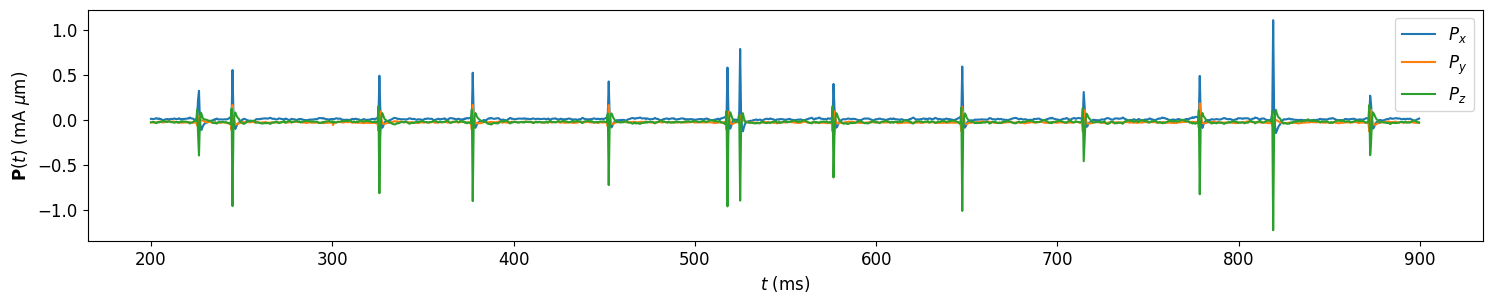

In [40]:
for popnumber in range(6):
    sim.analysis.plotDipole(showPop=cfg.S1cells[popnumber],figSize=(18, 3),timeRange=[200,900])


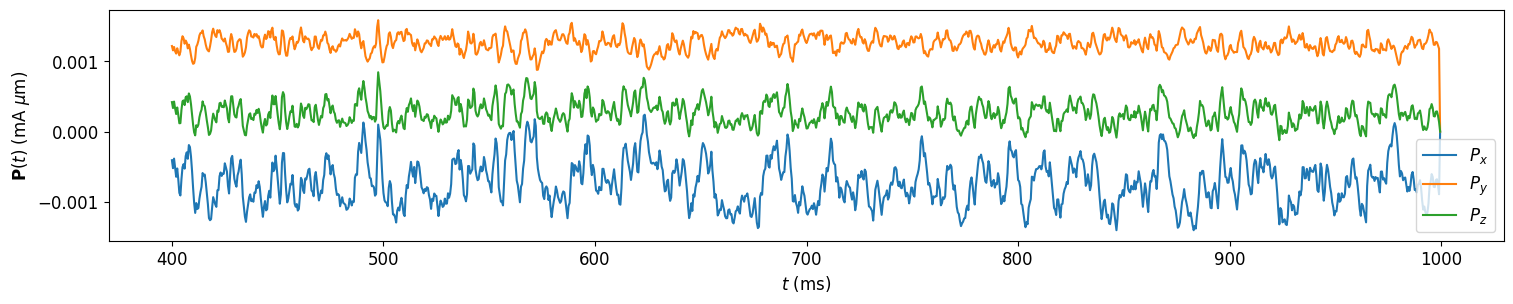

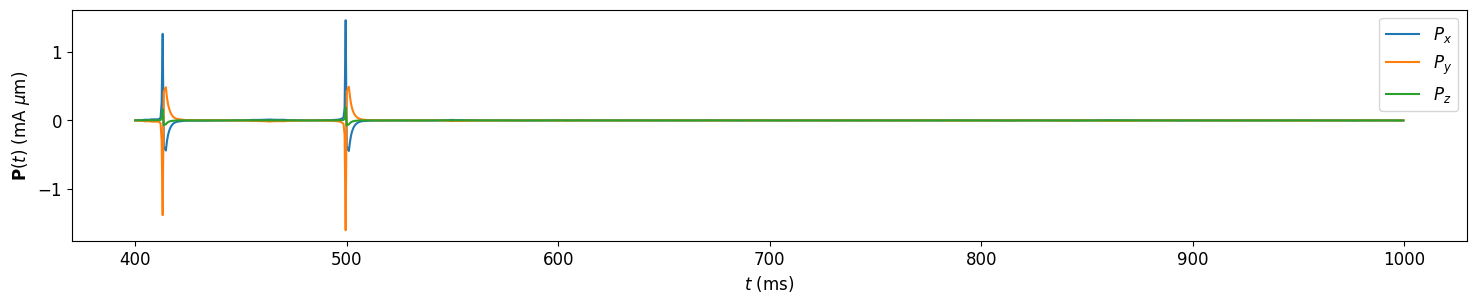

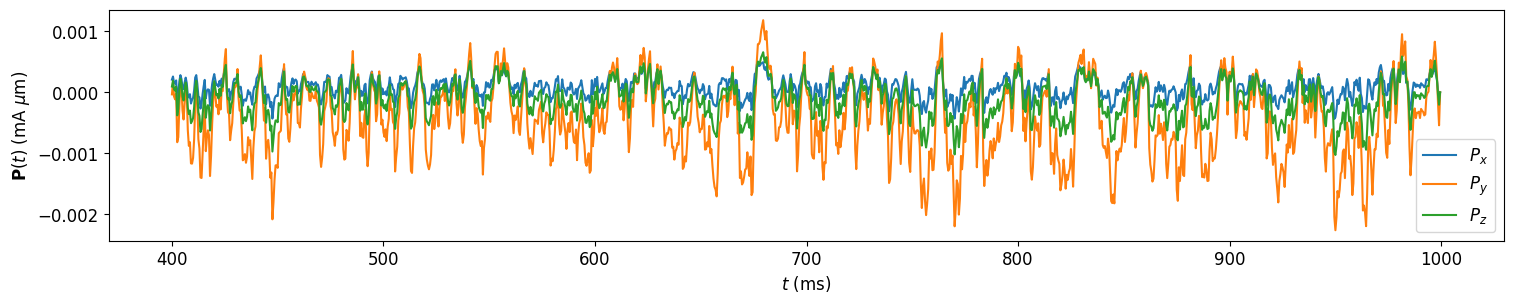

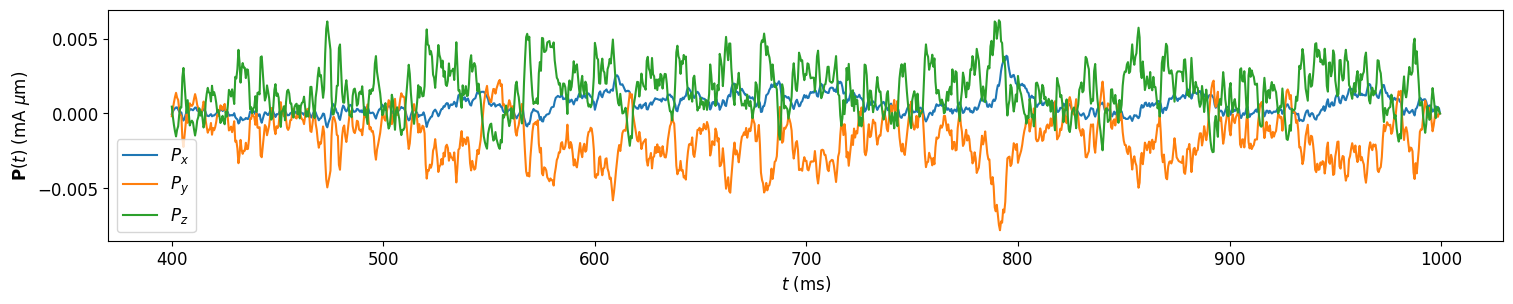

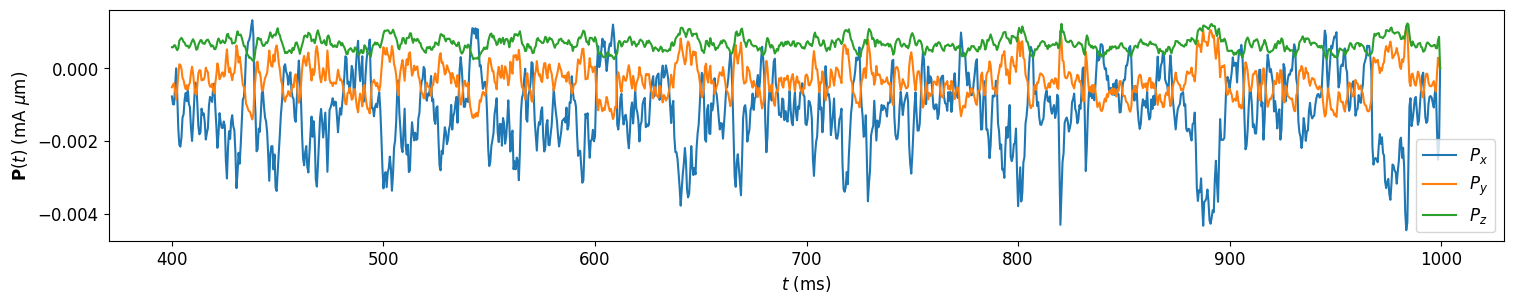

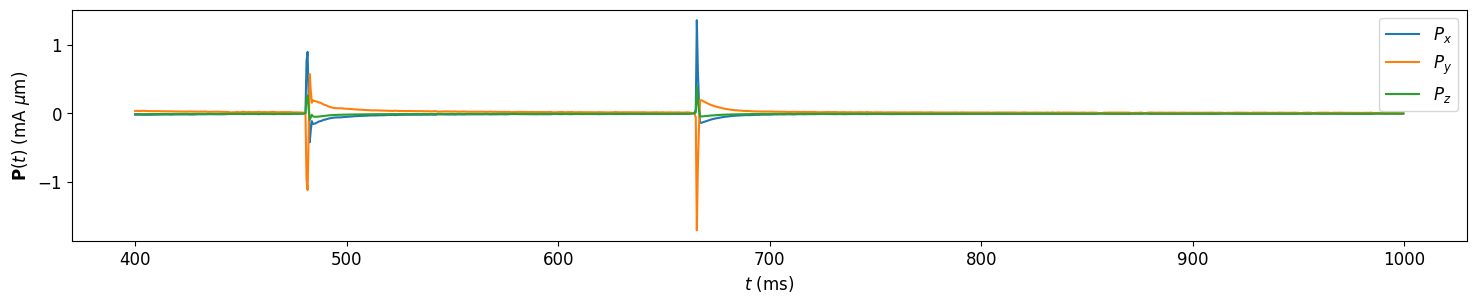

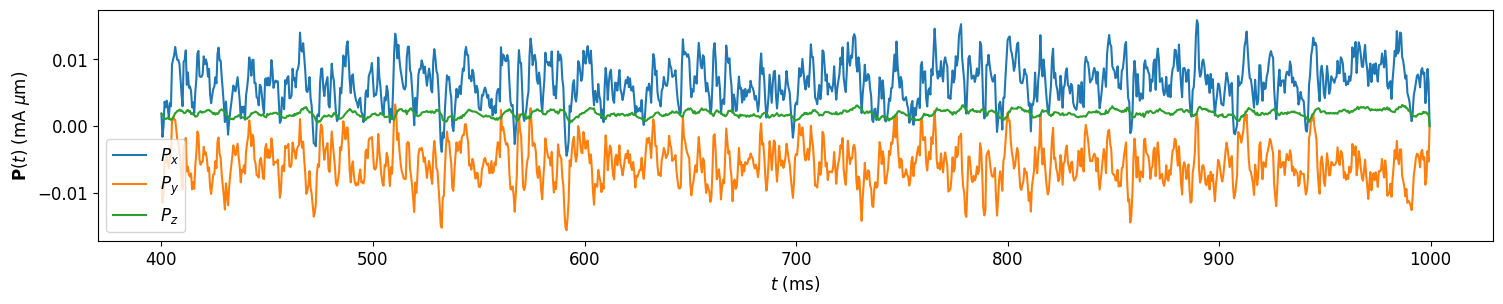

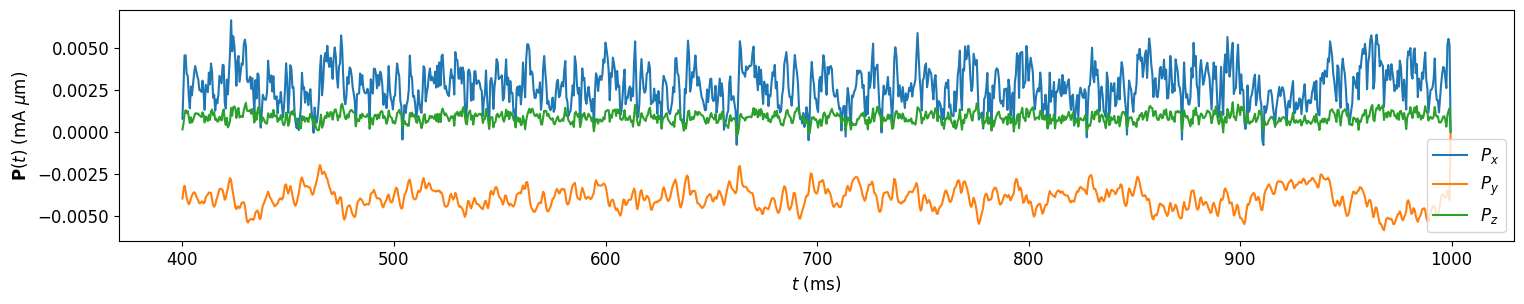

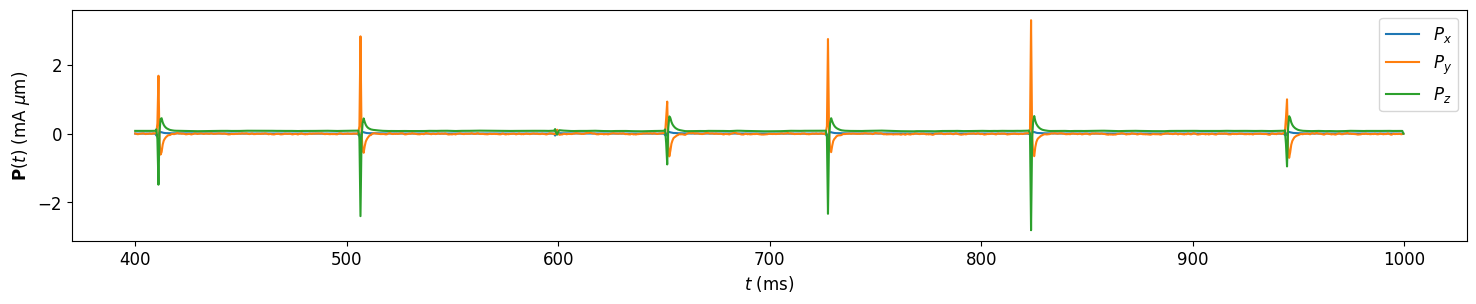

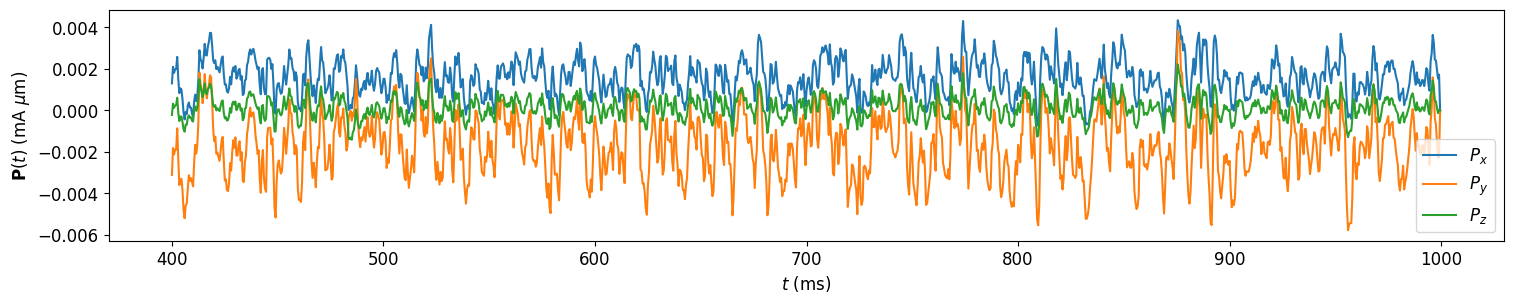

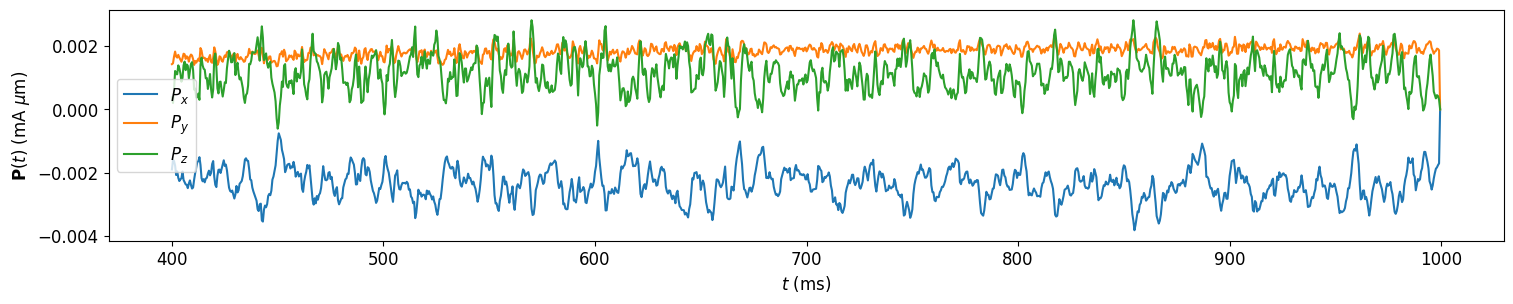

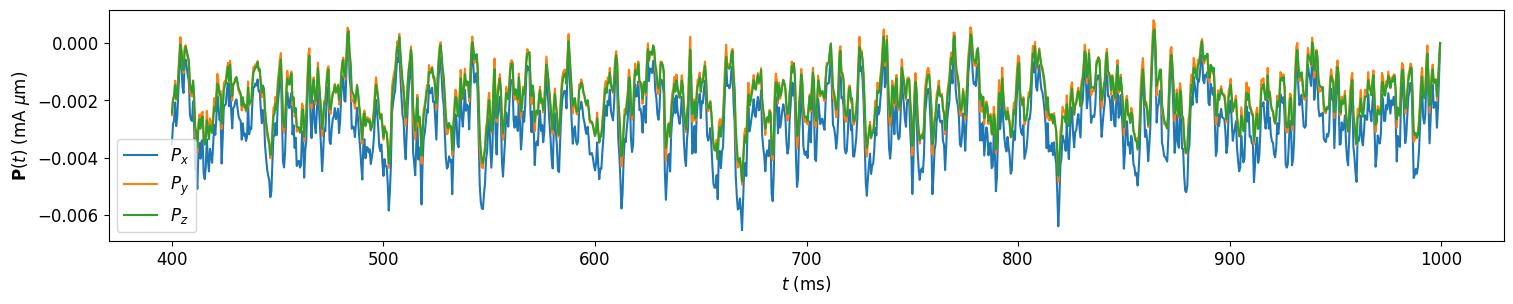

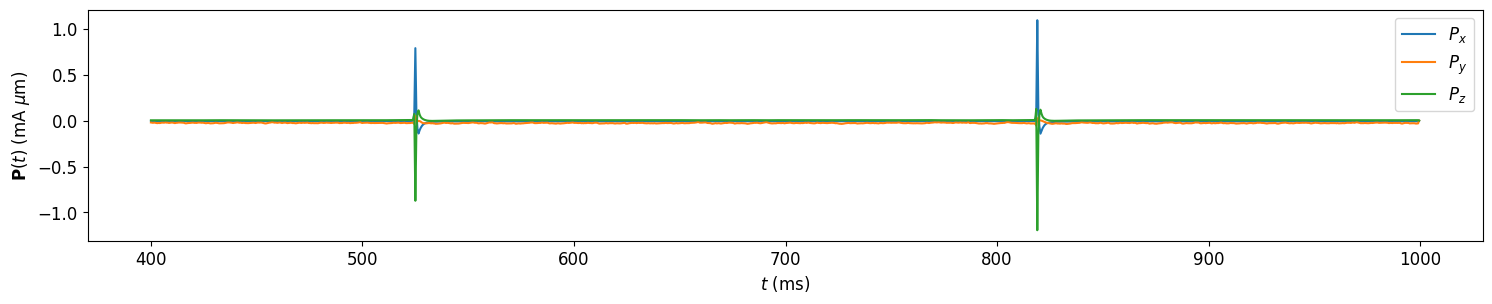

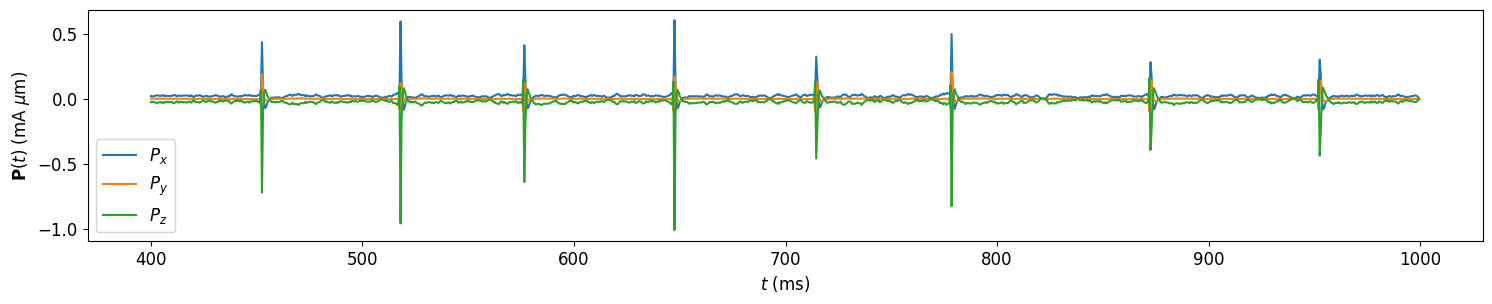

In [41]:
for cellnumber in range(1,15):
    sim.analysis.plotDipole(showCell=cellnumber,figSize=(18, 3),timeRange=[400,1000])

Plotting recorded cell traces ... trace


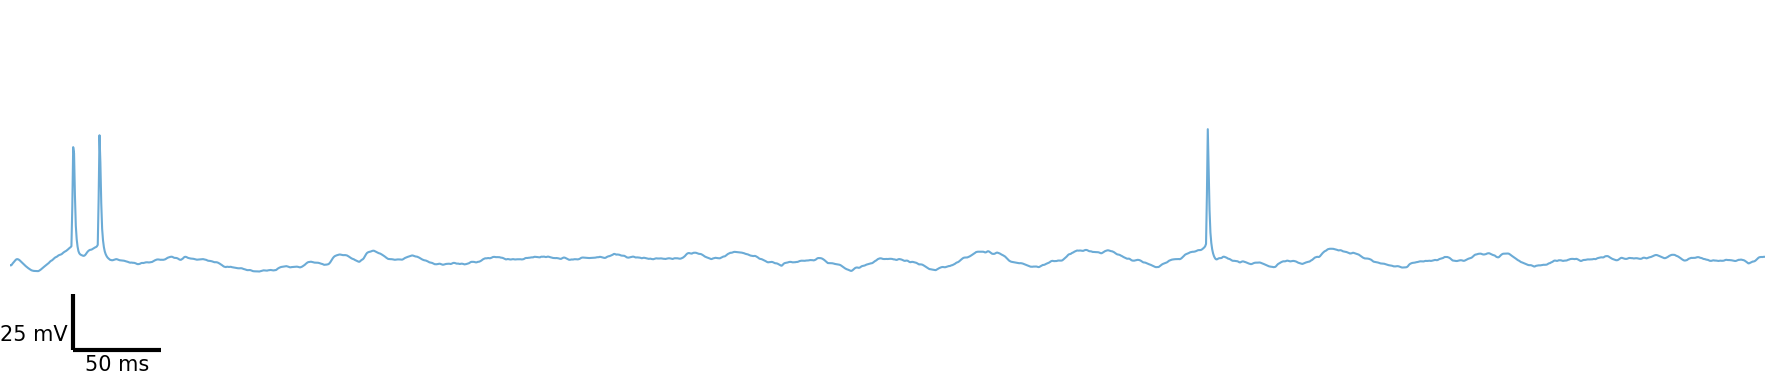

Plotting recorded cell traces ... trace


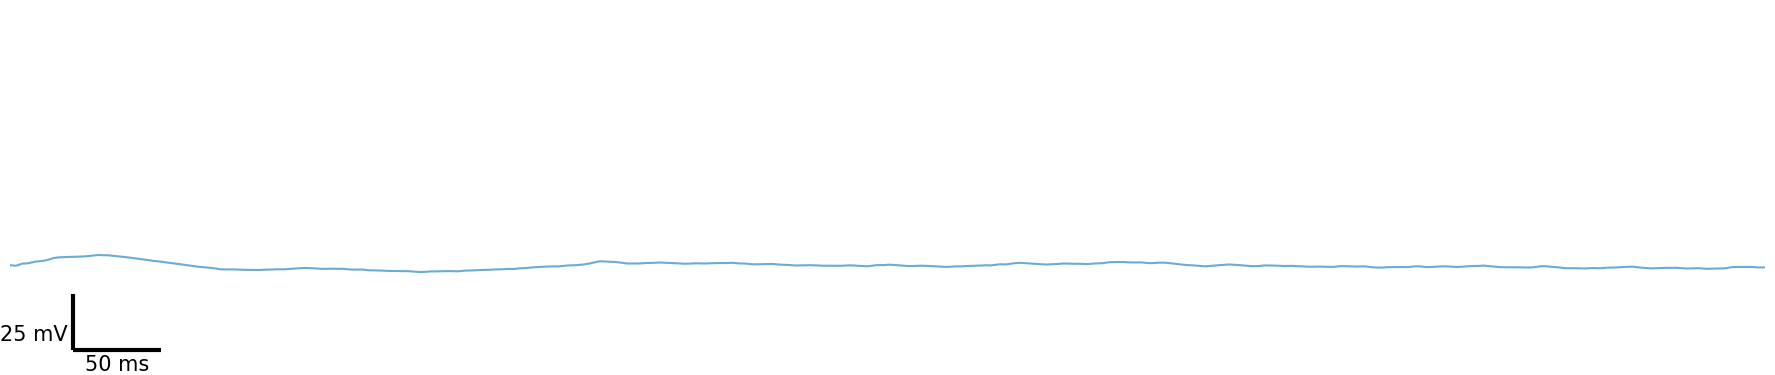

Plotting recorded cell traces ... trace


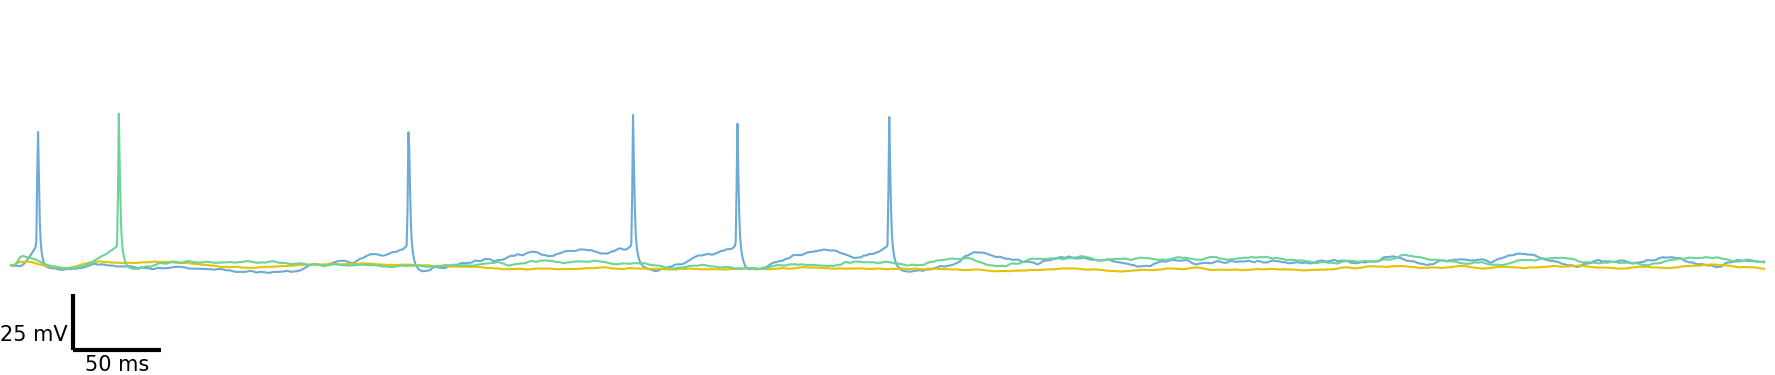

Plotting recorded cell traces ... trace


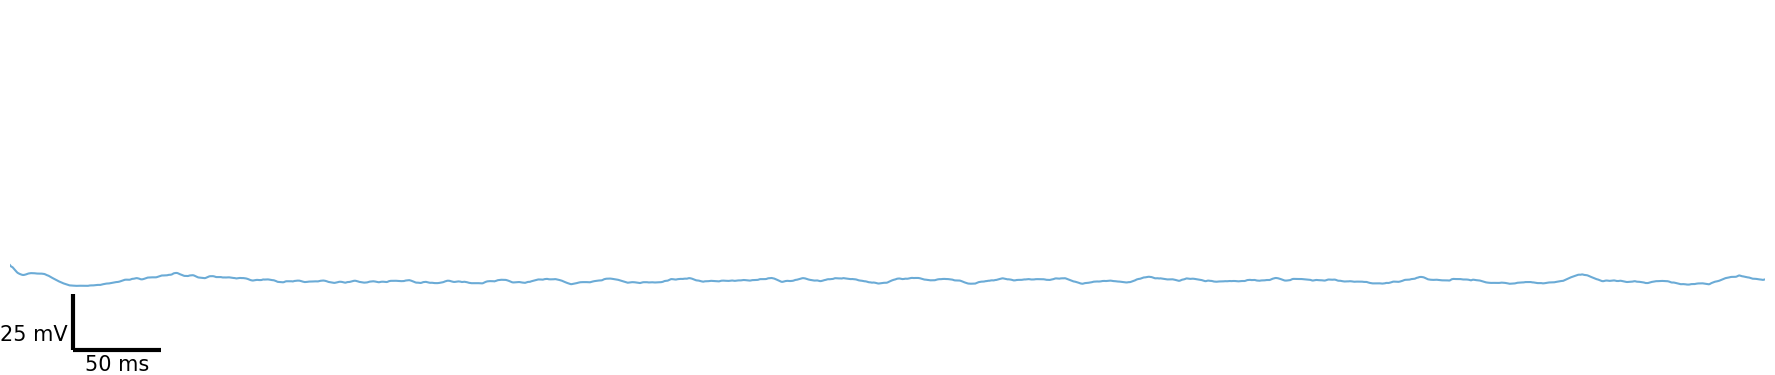

Plotting recorded cell traces ... trace


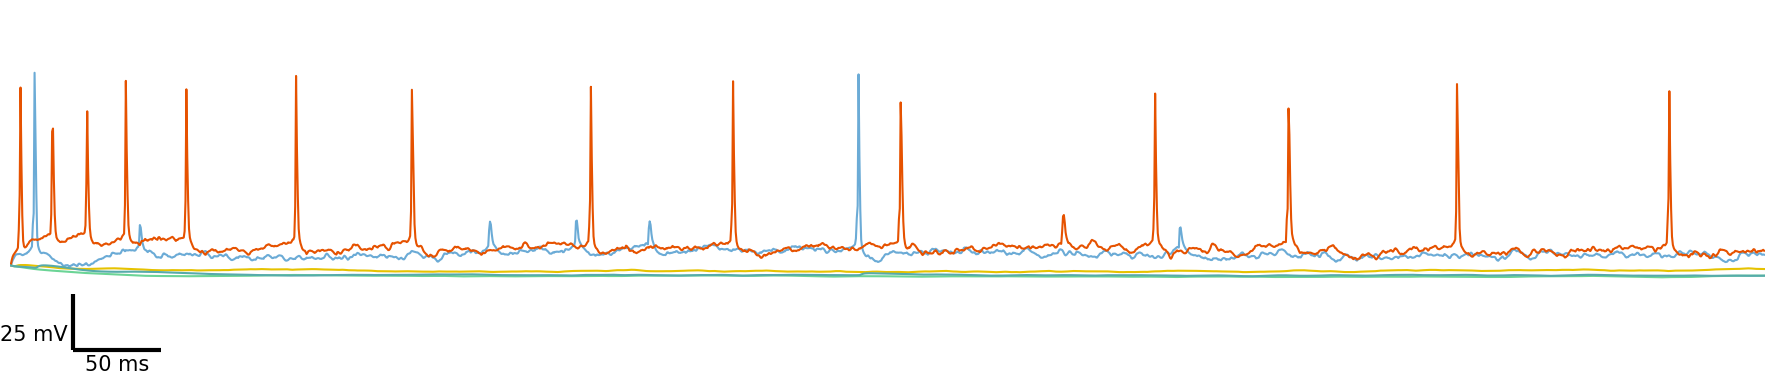

Plotting recorded cell traces ... trace


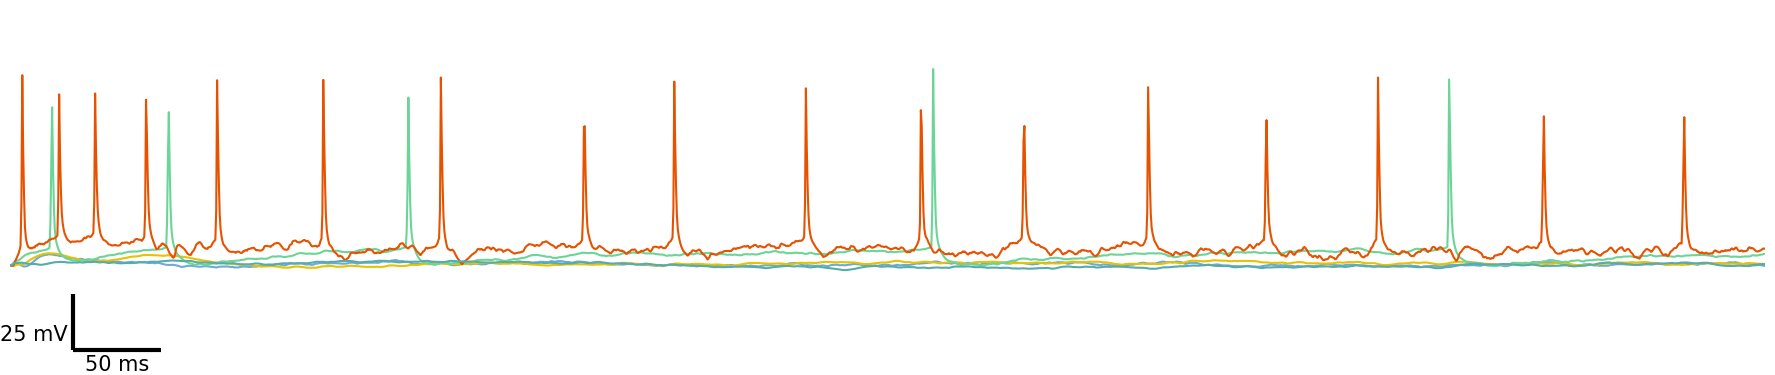

In [42]:
for pops in cfg.cellParamLabels:
#     print('\n\n',pops,'  N =',cfg.cellNumber[pops])
    sim.analysis.plotTraces(include=[pops], timeRange=[0,cfg.duration], overlay=True, oneFigPer='trace', subtitles=False, legend=False, ylim=[-110,50], axis=False, scaleBarLoc=3, figSize=(18, 4), fontSize=15, saveFig=False);

In [43]:
sim.net.cells[-1].stims

[{source: 'StimSynS1_S_all_EXC->L4_SP_0', type: 'NetStim', rate: 873.2941639344265, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[66], hObj: NetStim[29]},
 {source: 'StimSynS1_S_all_EXC->L4_SP_1', type: 'NetStim', rate: 982.4559344262298, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[76], hObj: NetStim[34]},
 {source: 'StimSynS1_S_all_EXC->L4_SP_2', type: 'NetStim', rate: 1091.617704918033, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[86], hObj: NetStim[39]},
 {source: 'StimSynS1_S_all_EXC->L4_SP_3', type: 'NetStim', rate: 1200.7794754098363, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[96], hObj: NetStim[44]},
 {source: 'StimSynS1_S_all_EXC->L4_SP_4', type: 'NetStim', rate: 1309.9412459016398, noise: 1.0, number: 1000000000.0, start: 0, seed: 4321, hRandom: Random[106], hObj: NetStim[49]},
 {source: 'StimSynS1_S_all_INH->L4_SP_0', type: 'NetStim', rate: 389.3586885245902, noise: 1

In [44]:
sim.net.cells[-1].conns

[]